# Next-Frame Video Prediction with Convolutional LSTMs

**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2021/06/05<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from PIL import Image
 
image1 = Image.open("/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct1/correct1.mp4_000005.903.jpg")

image1.show()

imag1_size = image1.size

print(imag1_size)

image1 = image1.resize((450, 163))

imag1_size = image1.size

print(imag1_size)

In [ ]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
folder_len=12
image_w = 64 #이미지의 크기를 모두 통일해준다
image_h = 64
label=1
for i in range(1):
  print(i)
  X = []
  groups_folder_path = "/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct31/"
  file_list = os.listdir(groups_folder_path) 
  for i in range(len(file_list)): 
      files = glob.glob(groups_folder_path+"/*.jpg")
      img = Image.open(groups_folder_path+str(file_list[i]))     #폴더를 열어주고 이미지를 읽음
      img = img.resize((image_w, image_h)) #이미지 크기를 모두 통일
      data = np.asarray(img) #숫자로
      imag_size = img.size

      print(imag_size)
      X.append(data) #리스트에 추가 
      
  X = np.array(X)
  xy = (X)
  np.save("/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct2.npy", xy) #그렇게 xy를 multi_image_data.npy로 저장
  

In [ ]:
for i in range(36):
  if(i==0):
    temp=np.load('/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct_npy/'+str(i+1)+'.npy')
  elif(i==1):
    temp1=np.load('/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct_npy/'+str(i+1)+'.npy')
    dataset = np.concatenate((temp, temp1),axis=3)
  else:
    temp=np.load('/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/추출된 올바른 이미지/correct_npy/'+str(i+1)+'.npy')
    dataset = np.concatenate((dataset, temp),axis=3)

In [ ]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
data = np.load(fpath)
len(data)

819208192/819200096 [==============================] - 51s 0us/step


20

In [ ]:
len(dataset)

50

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
# Download and load the dataset.


# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 3)
dataset = np.swapaxes(dataset,1,3)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


Training Dataset Shapes: (97, 49, 64, 64, 1), (97, 49, 64, 64, 1)
Validation Dataset Shapes: (11, 49, 64, 64, 1), (11, 49, 64, 64, 1)


In [ ]:
dataset = np.concatenate((dataset, data2),axis=3)

## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 6.


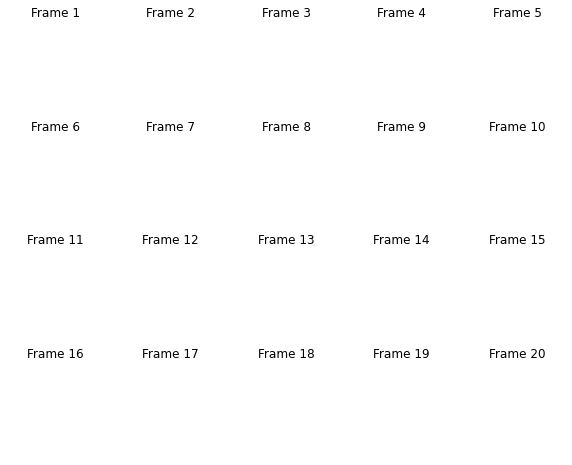

(97, 49, 64, 64, 1)


In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    #ax.imshow(train_dataset[data_choice][idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()
print(x_train.shape)
#Jupyter에서 실행시 잘보임

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 1 #batch_size를 최소화해야지 돌아감ㅠ
# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
97/97 [==============================] - 159s 2s/step - loss: nan - val_loss: nan
Epoch 2/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 3/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 4/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 5/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 6/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 7/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan
Epoch 8/10
97/97 [==============================] - 159s 2s/step - loss: nan - val_loss: nan
Epoch 9/10
97/97 [==============================] - 159s 2s/step - loss: nan - val_loss: nan
Epoch 10/10
97/97 [==============================] - 158s 2s/step - loss: nan - val_loss: nan


## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


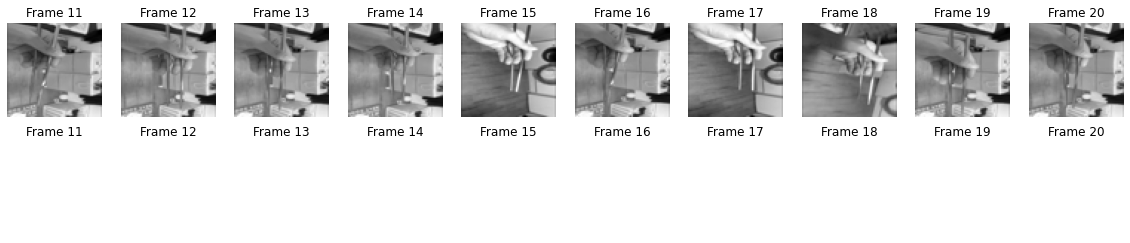

In [ ]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
